In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests

%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#Enlargen
sns.set_context('poster')

In [2]:
# Scrape Electoral Votes Series

r = requests.get('https://en.wikipedia.org/wiki/Electoral_College_(United_States)')
soup = BeautifulSoup(r.text, "lxml")

electoral_vote_table = soup.findAll('table','wikitable')[0] # Hard-coding that it's the first table

rows = electoral_vote_table.findAll('tr')

state_rows = [row.findAll('td')[1].getText().replace('*','')
                                            .replace('(−2)','')
                                            .replace('(+1)','')
                                            .replace('(+4)','')
                                            .replace('(+2)','')
                                            .replace('(−1)','') for row in rows[1:]]

state_rows = state_rows[:-1] # Drop last row with total electors

votes = [row.findAll('td')[0].getText().split()[0] for row in rows[1:-1]] 
# Votes are in first number in first column of all rows except first and last

electoral_vote_series = pd.Series(name='Electoral Votes')
for index, row in enumerate(state_rows):
    states = row.split(',')
    for state in states:
        electoral_vote_series[state.strip()] = votes[index]

In [3]:
# Scrape State Population Series

r = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population')
soup = BeautifulSoup(r.text, "lxml")

population_table = soup.findAll('table','wikitable')[0] # Hard-coding that it's the first table

rows = population_table.findAll('tr')
population_cells = [row.findAll('td')[3].contents for row in rows[1:53]] # Drop header row; population in fourth column
populations = [item for sublist in population_cells for item in sublist] # Un-nest

state_cells = [row.findAll('td')[2].contents for row in rows[1:53]] # Drop header row; population in third column
states = [cell[1].contents for cell in state_cells] # Need to skip flag information in state_cells
states = [item for sublist in states for item in sublist] # Un-nest

population_series = pd.Series(populations, index=states, name='July 2015 Population')

In [4]:
# Merge into one DF

df = pd.DataFrame([electoral_vote_series,population_series]).transpose()
df.drop('Puerto Rico', inplace=True) # You have great waves but no electoral votes
df['July 2015 Population'] = [int(x.replace(',','')) for x in df['July 2015 Population']]
df['Electoral Votes'] = [int(x) for x in df['Electoral Votes']]

equal_fractional_vote = df.sum()['Electoral Votes']/df.sum()['July 2015 Population']
df['Electoral Votes Per Capita'] = df['Electoral Votes']/df['July 2015 Population']
df['Percent Diff From Fair'] = (100*(df['Electoral Votes Per Capita'] - equal_fractional_vote))/equal_fractional_vote

largest_fractional_vote = df.sort_values('Percent Diff From Fair').ix[-1,'Electoral Votes Per Capita']
df['Percent Diff From Wyoming'] = (100*(df['Electoral Votes Per Capita'] - largest_fractional_vote))/largest_fractional_vote
df['Fraction of a Wyomingite'] = 100 + df['Percent Diff From Wyoming']

In [5]:
# Prep for JS Map

df_for_mapping = df[['Electoral Votes Per Capita','Percent Diff From Fair', 'Percent Diff From Wyoming']].copy()

df_for_mapping.reset_index(inplace=True)
df_for_mapping.columns = ['state', 'votespercap','difffair','diffwyoming']

df_for_mapping.to_csv('map_data.csv')

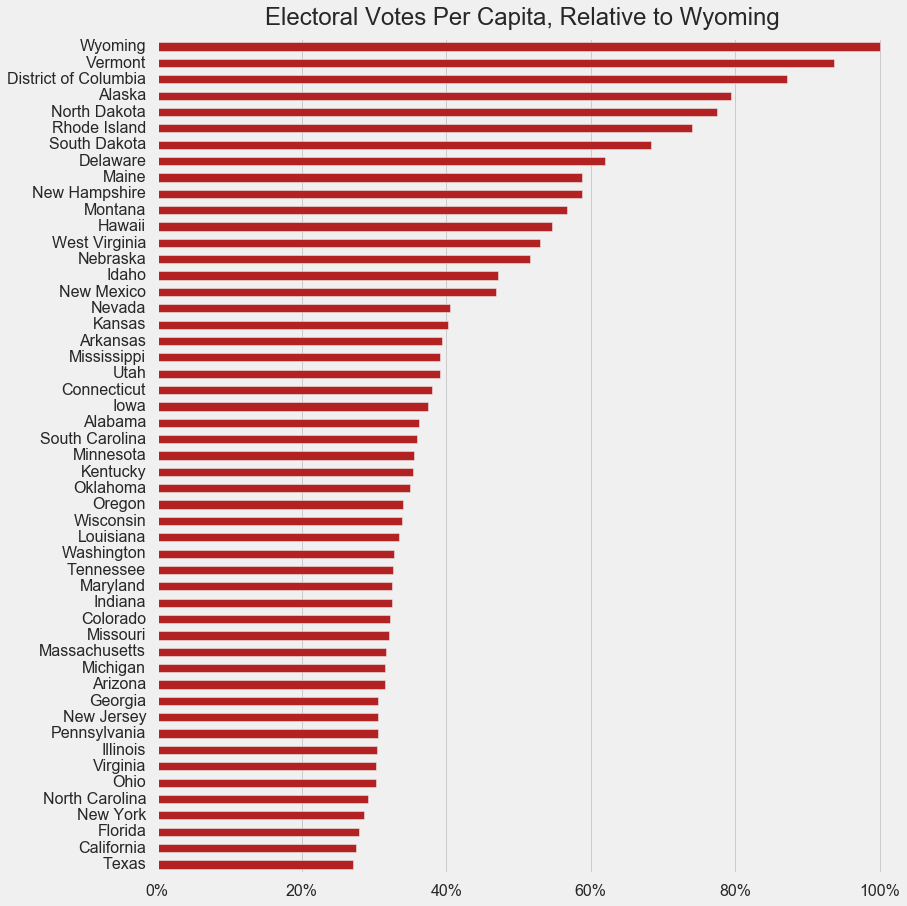

In [6]:
# pylab.rcParams['figure.figsize'] = [12.8, 8.8] # Old Vals for reference

pylab.rcParams['figure.figsize'] = [12.8, 12.8]

with plt.style.context('fivethirtyeight'):
    df['Fraction of a Wyomingite'].sort_values(ascending=True).plot(kind='barh', color='FireBrick', xlim=(0,101))
    plt.title('Electoral Votes Per Capita, Relative to Wyoming', y=1.01,fontsize=24)
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    plt.gca().yaxis.grid(False)
    plt.tight_layout()
    plt.savefig('./charts/vote_per_capita_relative_to_wyoming.png', dpi=200)

In [7]:
# Maybe/Someday:  Write out a very greedy "make it fair" algorithm; Swap electoral votes around
# to minimize the sum of the abs. vals. of % percent unfair; see how 2012 election would play out
# under that system